# SCE4104: Practical Applications of Computer Vision Assignment
## Part 1: Ball Tracking

How to use:

The below code performs and combines numerous calculations to produce a ball detection. Select which video (and corresponding annotations) you wish to track in the indicated lines of code, after ensuring that the paths to the videos and annotations are accurate.

If you wish to save the results to a csv file, set the correct path to a pre-existing csv file under the video-specific parameters section of code. Furthermore, ensure that within the while loop, the line calling the function ("results_tocsv(f,x,y)") is uncommented.

If you wish to view the video clip with the ground truth of the ball, together with the detected ball, ensure that the line ("cv2.imshow("Frame", frame)") is uncommented. If you wish to view the mask of the video clip with the applied pre-processing, ensure the line following the aforementioned, ("cv2.imshow("Mask", mask_erode)") is uncommented.

When changing video selection, restart the kernel and run all again.

In [1]:
import numpy as np
import cv2
import pandas as pd
import math
import matplotlib.pyplot as plt
import csv

Import video files

In [2]:
vid1 = cv2.VideoCapture("filmrole1.avi")
vid2 = cv2.VideoCapture("filmrole2.avi")
vid3 = cv2.VideoCapture("filmrole3.avi")
vid4 = cv2.VideoCapture("filmrole4.avi")
vid5 = cv2.VideoCapture("filmrole5.avi")
vid6 = cv2.VideoCapture("filmrole6.avi")

Read csv files and convert them to numpy array
Annotations are stored in the form: (frame, x, y)

In [3]:
vid1_ann = pd.DataFrame.to_numpy(pd.read_csv("Annotation Files/cam-1.csv"))
vid2_ann = pd.DataFrame.to_numpy(pd.read_csv("Annotation Files/cam-2.csv"))
vid3_ann = pd.DataFrame.to_numpy(pd.read_csv("Annotation Files/cam-3.csv"))
vid4_ann = pd.DataFrame.to_numpy(pd.read_csv("Annotation Files/cam-4.csv"))
vid5_ann = pd.DataFrame.to_numpy(pd.read_csv("Annotation Files/cam-5.csv"))
vid6_ann = pd.DataFrame.to_numpy(pd.read_csv("Annotation Files/cam-6.csv"))
print(vid1_ann.shape)
print(vid1_ann[0:3])

(2998, 3)
[[1 ' -' ' -']
 [2 ' -' ' -']
 [3 ' -' ' -']]


Choose which video to track

In [4]:
vid = vid1
vid_ann = vid1_ann

Declare the 'no ball present' special character, as found in ground truth

In [5]:
char = "-"

Set certain variables which depend on the video, such as:
- shape, centre and radius of template,
- number of pixels to omit from the top,
- minimum and maximum ball area,
- file to save results to (csv)

In [6]:
if vid == vid1:
    shape = (19,19,3)
    centre = (9,9)
    radius = 9
    y_top = 100
    area_min = 200
    area_max = 800
    path = 'E:/Engineering 4th Year/SCE4104 Practical Applications of Computer Vision/Assignment/Results_FINAL/vid1.csv'
elif vid == vid2:
    shape = (15,15,3)
    centre = (7,7)
    radius = 7
    y_top = 100
    area_min = 200
    area_max = 800
    path = 'E:/Engineering 4th Year/SCE4104 Practical Applications of Computer Vision/Assignment/Results_FINAL/vid2.csv'
elif vid == vid3:
    shape = (15,15,3)
    centre = (7,7)
    radius = 7
    y_top = 100
    area_min = 200
    area_max = 500
    path = 'E:/Engineering 4th Year/SCE4104 Practical Applications of Computer Vision/Assignment/Results_FINAL/vid3.csv'
elif vid == vid4:
    shape = (19,19,3)
    centre = (9,9)
    radius = 9
    y_top = 50
    area_min = 400
    area_max = 1000
    path = 'E:/Engineering 4th Year/SCE4104 Practical Applications of Computer Vision/Assignment/Results_FINAL/vid4.csv'
elif vid == vid5:
    shape = (13,13,3)
    centre = (6,6)
    radius = 6
    y_top = 50
    area_min = 200
    area_max = 800
    path = 'E:/Engineering 4th Year/SCE4104 Practical Applications of Computer Vision/Assignment/Results_FINAL/vid5.csv'
elif vid == vid6:
    shape = (15,15,3)
    centre = (7,7)
    radius = 7
    y_top = 100
    area_min = 200
    area_max = 800
    path = 'E:/Engineering 4th Year/SCE4104 Practical Applications of Computer Vision/Assignment/Results_FINAL/vid6.csv'

Construct template

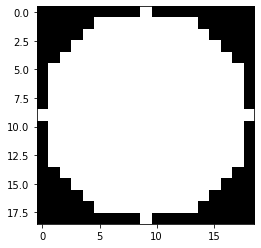

In [7]:
tmpl_back = np.zeros(shape=shape,dtype="uint8")
#ball_tmpl = cv2.ellipse(img=tmpl_back, center=centre,axes=(radius,2*radius//3),angle=180,startAngle=0,endAngle=360, color=(255,255,255), thickness=-1)
ball_tmpl = cv2.circle(tmpl_back, center=centre,radius=radius,color=(255,255,255), thickness=-1)
ball_tmpl = cv2.cvtColor(ball_tmpl, cv2.COLOR_BGR2GRAY)
plt.imshow(ball_tmpl,cmap='gray')

Define object detector

In [8]:
object_detector = cv2.createBackgroundSubtractorMOG2(history=100,varThreshold=40)

Function that performs preprocessing on the image frame

In [9]:
def preprocessing(frame):
        
    kernel = np.ones((3,3),dtype=np.uint8)
    
    # Object Detection: mask leaves unwanted objects black, objects of importance white
    mask = (object_detector.apply(frame))[y_top:,0:]
    mask_erode = cv2.erode(src=mask,kernel=kernel,iterations=1)
    mask_dilate = cv2.dilate(src=mask_erode,kernel=kernel,iterations=4)
    mask_erode = cv2.erode(src=mask_dilate,kernel=kernel,iterations=2)
    contours, _ = cv2.findContours(mask_erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    return contours, mask_erode

Function that performs computations about ball criteria

In [10]:
def gen_score(hull,ROI,xrect,yrect):
    score = []
    global scores_cnt
    
    if ROI.shape[0] > ball_tmpl.shape[0] and ROI.shape[1] > ball_tmpl.shape[1]:
        tmpl_match = cv2.matchTemplate(image=ROI,templ=ball_tmpl,method=cv2.TM_SQDIFF)
        min_score, _, min_loc, _ = cv2.minMaxLoc(tmpl_match)
        score.append(min_score)
    
    else:
        score.append(0)
    
    if (w/h) > 0.7:
        (x,y), rad = cv2.minEnclosingCircle(cnt)
        area = math.pi*rad*rad
        if area > area_min and area < area_max:
            score.append(x)
            score.append(y)
            score.append(rad)
        else:
            score.append(0)
            score.append(0)
            score.append(0)
    else:
        score.append(0)
        score.append(0)
        score.append(0)
            
    scores_cnt.append(score)

Function that analyses detected contours and their properties and decides which contours qualify for a ball

In [11]:
def plot_ball():
    #print(scores_cnt)
    # The rows 'eligible' for plotting in scores_cnt are those which have a template match value and co ordinates
    for row in scores_cnt:
        num_nonzero = np.count_nonzero(row)
        if num_nonzero == 4:
            eligible.append(row)
        else:
            1
    if eligible != []:
        min_score = np.min(a=eligible,axis=0)
        x = int(min_score[1])
        y = int(min_score[2])
        rad =int(min_score[3])
        cv2.circle(frame, (x,y+y_top), rad, (255,0,0), 3)
        cv2.putText(frame, "Detected", (x,y+(2*rad)+y_top), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
    else:
        x = 2000
        y = 2000
        
    return x, y

Functions that plots the ground truth of the ball where it has been provided

In [12]:
def plot_groundtruth(f):
    # Plot the ground truth, where it exists, assuming a radius of 15
    x_ann = ann[f,1]
    y_ann = ann[f,2]
    if not any(c in x_ann for c in char):
        x_ann = int(x_ann)
        y_ann = int(y_ann)
        cv2.circle(frame, (x_ann,y_ann), 15, (0,0,255), 3)
        cv2.putText(frame, "Actual", (x_ann,y_ann+(2*15)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)

Function that saves results to a csv file

In [13]:
def results_tocsv(f, x, y): 
    f = f+1
    if x!=2000 and y!=2000:
        y = y + y_top
        row = [f, x, y]
    else:
        row = [f, '-', '-']
    # open the file in append mode
    with open(file=path, mode='a',newline="") as file:
        # create the csv writer
        writer = csv.writer(file)
        # write a row to the csv file
        writer.writerow(row)

Load video and call required functions. Show the desired windows, and plot the ground truth bounding boxes where it exists.

In [14]:
#Loading Video
cap = vid
ann = vid_ann

f = 0

while cap.isOpened():
    ret, frame = cap.read()
    
    if ret == True:
        hull = []
        scores_cnt = []
        eligible = []

        # Function that performs background subtraction and morphological operations to the frame
        # to return contours of moving objects
        contours, mask_erode = preprocessing(frame)

        for cnt in contours:
            # Apply convex hull to obtain a rectangle that fits the objects
            hull = cv2.convexHull(cnt)
            xrect, yrect, w, h = cv2.boundingRect(hull)
            ROI = frame[xrect:xrect+w,yrect:yrect+h]
            # Ensure that the ROI is in grayscale
            if len(ROI) > 0:
                ROI_gray = cv2.cvtColor(src=ROI, code=cv2.COLOR_BGR2GRAY)
            else:
                ROI_gray = ROI

            # Call function to perform template matching on the region of interest
            gen_score(hull,ROI_gray,xrect,yrect)

        # Call function to check which contours satisfy criteria for detected ball and plot
        x,y = plot_ball()           

        # Call function which plots the ground truth
        plot_groundtruth(f)

        # Call function which saves data to csv
        #results_tocsv(f,x,y)

        cv2.imshow("Frame", frame)
        #cv2.imshow("Mask", mask_erode)

        f = f + 1

        key = cv2.waitKey(2)
        if key == 27:
            break
    
    else:
        break
        
cap.release()
cv2.destroyAllWindows()